# Importing Libraries

In [26]:
import pandas as pd
import numpy as np
import sklearn

# Reading and preparing data

According to what we decided during previous stages, we will remove columns with high correlation, remove outliers (with automatic detection) and use box cox and standard scaler on our data.

In [27]:
df_train=pd.read_csv('../data/for_modelling/credit_score_train.csv')
df_val=pd.read_csv('../data/for_modelling/credit_score_valid.csv')
df = pd.concat([df_train, df_val])
df

,INCOME,SAVINGS,DEBT,R_SAVINGS_INCOME,R_DEBT_INCOME,R_DEBT_SAVINGS,T_CLOTHING_12,T_CLOTHING_6,R_CLOTHING,R_CLOTHING_INCOME,...,R_EXPENDITURE_SAVINGS,R_EXPENDITURE_DEBT,CAT_GAMBLING,CAT_DEBT,CAT_CREDIT_CARD,CAT_MORTGAGE,CAT_SAVINGS_ACCOUNT,CAT_DEPENDENTS,CREDIT_SCORE,DEFAULT
0,2783,1855,0,0.6665,0.0000,0.0000,103,74,0.7184,0.0370,...,2.5003,0.0000,No,0,0,0,1,0,570,0
1,314430,445442,707468,1.4167,2.2500,1.5882,35861,29157,0.8131,0.1141,...,0.5882,0.3704,High,1,0,1,1,0,691,0
2,161773,517674,2782496,3.2000,17.2000,5.3750,3716,2533,0.6816,0.0230,...,0.3125,0.0581,No,1,1,1,1,1,520,0
3,16014,97685,20818,6.1000,1.3000,0.2131,637,187,0.2936,0.0398,...,0.1639,0.7692,No,1,0,0,1,0,654,0
4,193225,1410542,2589215,7.3000,13.4000,1.8356,5276,2325,0.4407,0.0273,...,0.1370,0.0746,No,1,1,0,1,1,552,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133,386976,1250231,654883,3.2308,1.6923,0.5238,36665,30569,0.8337,0.0947,...,0.2381,0.4545,No,1,0,0,1,0,562,0
134,16772,8386,0,0.5000,0.0000,0.0000,238,186,0.7815,0.0142,...,2.5000,0.9786,No,0,0,0,1,0,619,0
135,137509,206264,206264,1.5000,1.5000,1.0000,15661,10865,0.6938,0.1139,...,0.6667,0.6667,No,1,0,0,1,0,639,1
136,259146,1922000,1662854,7.4167,6.4167,0.8652,12180,8527,0.7001,0.0470,...,0.1124,0.1299,High,1,1,0,1,1,587,1


### setting target

In [28]:
target = 'DEFAULT'

### removing columns and mapping

In [29]:
# columns to remove from EDA
columns_to_remove = ["T_CLOTHING_12","T_ENTERTAINMENT_12", "T_GROCERIES_12", "T_GROCERIES_6", "T_HEALTH_12", "T_TAX_12", "T_TAX_6", "T_TRAVEL_12", "T_TRAVEL_6","T_UTILITIES_12", "T_UTILITIES_6", "T_EXPENDITURE_12", "T_EXPENDITURE_6"]
# remove columns with high correlation
df_train.drop(columns=columns_to_remove, inplace=True)
df_val.drop(columns=columns_to_remove, inplace=True)

# map CAT_GAMBLING (No-0, Low-1, High-2)
df_train['CAT_GAMBLING'] = df_train['CAT_GAMBLING'].map({'No':0, 'Low':1, 'High':2})
df_val['CAT_GAMBLING'] = df_val['CAT_GAMBLING'].map({'No':0, 'Low':1, 'High':2})

### removing outliers

In [30]:
from pyod.models.knn import KNN
clf = KNN(contamination=0.04)
rest_cols = [col for col in df_train.columns if col not in columns_to_remove]
# remove DEFAULT column
rest_cols.remove('DEFAULT')
clf.fit(df_train[rest_cols])
df_train['outliers'] = clf.labels_
# sum of outliers
df_train['outliers'].value_counts()

0    470
1     20
Name: outliers, dtype: int64

In [31]:
df_train = df_train[df_train['outliers'] == 0]
df_train.drop(columns='outliers', inplace=True)
df_train.reset_index(drop=True, inplace=True)
df_train

,INCOME,SAVINGS,DEBT,R_SAVINGS_INCOME,R_DEBT_INCOME,R_DEBT_SAVINGS,T_CLOTHING_6,R_CLOTHING,R_CLOTHING_INCOME,R_CLOTHING_SAVINGS,...,R_EXPENDITURE_SAVINGS,R_EXPENDITURE_DEBT,CAT_GAMBLING,CAT_DEBT,CAT_CREDIT_CARD,CAT_MORTGAGE,CAT_SAVINGS_ACCOUNT,CAT_DEPENDENTS,CREDIT_SCORE,DEFAULT
0,2783,1855,0,0.6665,0.0000,0.0000,74,0.7184,0.0370,0.0555,...,2.5003,0.0000,0,0,0,0,1,0,570,0
1,314430,445442,707468,1.4167,2.2500,1.5882,29157,0.8131,0.1141,0.0805,...,0.5882,0.3704,2,1,0,1,1,0,691,0
2,161773,517674,2782496,3.2000,17.2000,5.3750,2533,0.6816,0.0230,0.0072,...,0.3125,0.0581,0,1,1,1,1,1,520,0
3,16014,97685,20818,6.1000,1.3000,0.2131,187,0.2936,0.0398,0.0065,...,0.1639,0.7692,0,1,0,0,1,0,654,0
4,193225,1410542,2589215,7.3000,13.4000,1.8356,2325,0.4407,0.0273,0.0037,...,0.1370,0.0746,0,1,1,0,1,1,552,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
465,20007,22508,457665,1.1250,22.8752,20.3334,861,0.5934,0.0725,0.0645,...,1.1111,0.0546,0,1,0,0,1,0,423,0
466,20846,268679,23162,12.8888,1.1111,0.0862,533,0.4094,0.0625,0.0048,...,0.0862,1.0000,1,1,0,0,1,0,584,0
467,89235,1106514,160623,12.4000,1.8000,0.1452,835,0.3460,0.0270,0.0022,...,0.0806,0.5556,0,1,0,0,1,0,631,0
468,197073,1021195,1863233,5.1818,9.4545,1.8246,3948,0.4691,0.0427,0.0082,...,0.1754,0.0962,2,1,0,1,1,1,572,0


### using box cox and standard scaler

In [32]:
# using box cox and standard scaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
from sklearn.preprocessing import PowerTransformer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from scipy.stats import boxcox

X=df_train.drop(target, axis=1)
y=df_train[target]
X=X[rest_cols]
X_val=df_val.drop(target, axis=1)
y_val=df_val[target]
X_val=X_val[rest_cols]

# Box Cox and standart scalling
cox_box_model = PowerTransformer(method='yeo-johnson')
X = cox_box_model.fit_transform(X)
X_val = cox_box_model.transform(X_val)
X = scaler.fit_transform(X)
X_val = scaler.transform(X_val)

# Data is ready :))

# Explainable AI

We will be doing it on those models from previous part, which we found the best.
It will be:
- naive bayes
- xgdboost
- tpot
- soft voting

## Naive Bayes

In [33]:
# installing and setting up naive bayes
# !pip install xgboost
from sklearn.naive_bayes import GaussianNB
model_naive_bayes = GaussianNB(var_smoothing=1e-05)
model_naive_bayes.fit(X, y)

GaussianNB(var_smoothing=1e-05)

## XGBoost

In [34]:
# !pip install xgboost
from xgboost import XGBClassifier
model_xgboost=XGBClassifier(random_state=1,
                            learning_rate=0.01,
                            booster='gbtree',
                            max_depth=4
                            )
model_xgboost.fit(X, y)

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=1, ...)

### SHAP

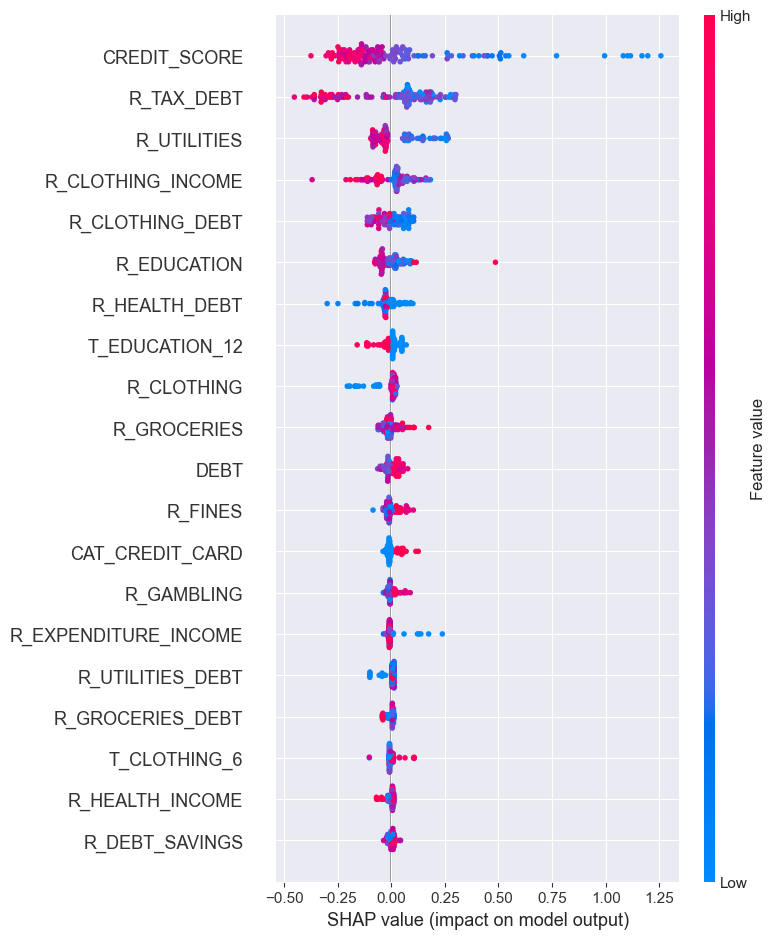

In [36]:
# !pip install shap
import shap
explainer_shap_xgboost = shap.TreeExplainer(model_xgboost)
shap_values_xgboost = explainer_shap_xgboost.shap_values(X_val)
#visualizing SHAP
shap.summary_plot(shap_values_xgboost, X_val, rest_cols)